## The `TFRecord` binary format

A TFRecord file is just a list of binary records. You can create one using a `tf.io.TFRecordWriter`:

In [157]:
import tensorflow as tf
import numpy as np
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt


In [158]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 

In [159]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is FA43-03D6

 Directory of C:\Users\cataluna84\Documents\handson-ml2

19-11-2020  21:45    <DIR>          .
20-11-2020  09:55    <DIR>          ..
12-11-2020  07:52    <DIR>          .git
22-10-2020  07:10               281 .gitignore
19-11-2020  21:45    <DIR>          .idea
15-11-2020  23:09    <DIR>          .ipynb_checkpoints
19-11-2020  20:58    <DIR>          .virtual_documents
19-11-2020  20:59    <DIR>          __pycache__
22-10-2020  07:10           287,745 01_the_machine_learning_landscape.ipynb
22-10-2020  07:10         1,237,750 02_end_to_end_machine_learning_project.ipynb
22-10-2020  07:10           466,033 03_classification.ipynb
22-10-2020  07:10           769,117 04_training_linear_models.ipynb
22-10-2020  07:10           910,278 05_support_vector_machines.ipynb
22-10-2020  07:10           219,024 06_decision_trees.ipynb
22-10-2020  07:10           551,625 07_ensemble_learning_and_random_forests.ipynb
22-10-2020  0

In [160]:
%pwd


              13 Dir(s)  268,610,170,880 bytes free


'C:\\Users\\cataluna84\\Documents\\handson-ml2'

In [161]:
%dirs

[]

In [162]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a `tf.data.TFRecordDataset`:

In [163]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, 
but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [164]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]

for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [165]:
options = tf.io.TFRecordOptions(compression_type="GZIP")

with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [166]:
dataset = tf.data.TFRecordDataset(
    ["my_compressed.tfrecord"],
    compression_type="GZIP"
)

for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Intro to Protocol Buffers

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads).
In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol
buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about
protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will
use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [167]:
# %%writefile person.proto

# syntax = "proto3";
# message Person {
#   string name = 1;
#   int32 id = 2;
#   repeated string email = 3;
# }


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for
the `tf.io.decode_proto()` example below):

In [168]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [169]:
%ls person.proto

 Volume in drive C has no label.
 Volume Serial Number is FA43-03D6

 Directory of C:\Users\cataluna84\Documents\handson-ml2

12-11-2020  10:58               110 person.proto
               1 File(s)            110 bytes
               0 Dir(s)  268,609,646,592 bytes free


In [170]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [171]:
person.name  # read a field

'Al'

In [172]:
person.name = "Alice"  # modify a field

In [173]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [174]:
person.email.append("c@d.com")  # add an email address

In [175]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [176]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [177]:
person == person2  # now they are equal

True

#### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow.
For this you can use the `tf.io.decode_proto()` function:

In [178]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc"
)

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

### TensorFlow Protobufs

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

**Warning**: there's currently a bug preventing `from tensorflow.train import X` so we work around it
by writing `X = tf.train.X`. See https://github.com/tensorflow/tensorflow/issues/33289 for more details.

In [179]:
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [180]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [181]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2420afc2c10>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [182]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [183]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [184]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### Putting Images in TFRecords

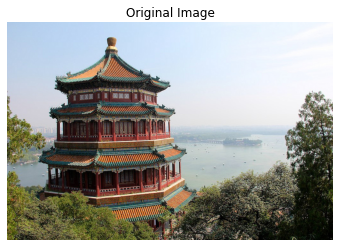

In [185]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()


In [186]:
data = tf.io.encode_jpeg(img)

example_with_image = Example(
    features=Features(
        feature = {
            "image": Feature(bytes_list=BytesList(value=[data.numpy()]))
        }
    )
)
serialized_example = example_with_image.SerializeToString()
print(serialized_example)
# then save to TFRecord

b'\n\xf9\xd3\x08\n\xf5\xd3\x08\n\x05image\x12\xea\xd3\x08\n\xe6\xd3\x08\n\xe2\xd3\x08\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUV

In [187]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

example_with_image = tf.io.parse_single_example(serialized_example, feature_description)

decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

In [188]:
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

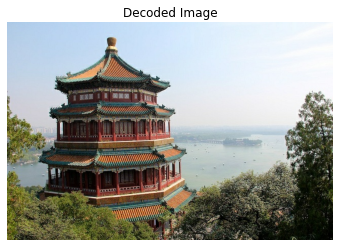

In [189]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

### Putting Tensors and Sparse Tensors in TFRecords

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [190]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [191]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [192]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [193]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [194]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)

for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [195]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2420c11ceb0>}

## Handling Sequential Data Using `SequenceExample`

In [196]:
# ```proto
# syntax = "proto3";
#
# message FeatureList { repeated Feature feature = 1; };
# message FeatureLists { map<string, FeatureList> feature_list = 1; };
# message SequenceExample {
#   Features context = 1;
#   FeatureLists feature_lists = 2;
# };
# ```

**Warning**: there's currently a bug preventing `from tensorflow.train import X` so we work around it by
writing `X = tf.train.X`. See https://github.com/tensorflow/tensorflow/issues/33289 for more details.

In [197]:
# from tf.train import FeatureList, FeatureLists, SequenceExample

FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(
    feature = {
        "author_id": Feature(int64_list = Int64List(value=[123])),
        "title": Feature(bytes_list = BytesList(value=[b"A", b"desert", b"place", b"."])),
        "pub_date": Feature(int64_list = Int64List(value=[1623, 12, 25]))
    }
)

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(
        bytes_list = BytesList(
            value = [word.encode("utf-8") for word in words]
        )
    )

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context = context,
    feature_lists = FeatureLists(
        feature_list = {
            "content": FeatureList(feature=content_features),
            "comments": FeatureList(feature=comments_features)
        }
    )
)

In [198]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [199]:
serialized_sequence_example = sequence_example.SerializeToString()

In [200]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [201]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2420b413670>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [202]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [203]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2420b413a00>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2420b4138e0>}

In [204]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# The Features API

Let's use the variant of the California housing dataset that we used in Chapter 2, since it contains
categorical features and missing values:

In [205]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [206]:
fetch_housing_data()

In [207]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [208]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [209]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [210]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [211]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1

housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", 
    normalizer_fn=lambda x: (x - age_mean) / age_std
)

In [212]:
median_income = tf.feature_column.numeric_column("median_income")

bucketized_income = tf.feature_column.bucketized_column(
    median_income, 
    boundaries=[1.5, 3., 4.5, 6.]
)

In [213]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [214]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [215]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [216]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000
)

city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [217]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age,
    boundaries=[-1., -0.5, 0., 0.5, 1.]
) # age was scaled

age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity],
    hash_bucket_size=100
)

In [218]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")

bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))

bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))

location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude],
    hash_bucket_size=1000
)

In [219]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

ocean_proximity_one_hot

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

In [220]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity, dimension=2)
ocean_proximity_embed

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002420A938370>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)

### Using Feature Columns for Parsing

In [221]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [222]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [223]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=x)),
            "median_house_value": Feature(float_list=FloatList(value=y))
        }))
        f.write(example.SerializeToString())

In [224]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [225]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32

dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])

dataset = dataset.repeat()\
    .shuffle(10000)\
    .batch(batch_size)\
    .map(parse_examples)

FIXED

**Warning**: the `DenseFeatures` layer currently does not work with the Functional API,
see [TF issue #27416](https://github.com/tensorflow/tensorflow/issues/27416). Hopefully this will
be resolved before the final release of TF 2.0.

In [226]:
columns_without_target = columns[:-1]

model = tf.keras.models.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=columns_without_target),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(lr=1e-3),
    metrics=["accuracy"]
)

model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
362/362 [==============================] - 2s 6ms/step - loss: 3.7619 - accuracy: 0.0016

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [227]:
some_columns = [ocean_proximity_embed, bucketized_income]

dense_features = tf.keras.layers.DenseFeatures(some_columns)

dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.14504611,  0.7563394 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.1119912 ,  0.56957847],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.1119912 ,  0.56957847]], dtype=float32)>

##12th Nov



